In [27]:
import base64
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

# Thoughts on implementing stochastic epidemic models

This short notebook is intended to offer some thoughts on how to implement stochastic epidemic models in code.  The aim is to provide a clean, flexible, and yet efficient pattern for those implementing a stochastic model for the first time.  The concepts are (almost) language agnostic, though the examples will be shown in Python.

In particular, the concepts presented here are used in [`gemlib`](https://gitlab.com/gem-epidemics/gemlib), and should give a reasonable introduction to those wishing to work with and extend `gemlib`.

## The SIR model: a recap

In the standard homogeneously mixing SIR model, we have that individuals exist in three mutually exclusive states: S(usuceptible), I(nfectious), and R(emoved), collectively $X = (S, I, R)^T$.  

We assume that for a _single individual_, the transition rates are
\begin{align}
\lambda^{\mathrm{SI}}(X_t) &= \beta I_t/N \\
\lambda^{\mathrm{IR}}(X_t) &= \gamma \\
\end{align}
such that the $S\rightarrow I$ transition is coupled to the current _prevalence_ of infectious individuals, but infectious individuals transition to being removed at constant rate $\gamma$.

In [2]:
mm("""
flowchart LR
  S-- "#946;"I/N -->I
  I -- "#947;" --> R
""")

Given a starting set of conditions $X_0 = (S_0, I_0, R_0)^T$, we can propagate the system forward in time.  

In the stochastic setting we have
\begin{align}
Pr(I_{t+\delta t} - I_{t} = 1 | X_{t}) &= \beta I_t / N + o(\delta t) \\
Pr(I_{t+\delta t} - I_{t} = -1 | X_{t}) &= \gamma + o(\delta t) \\
\end{align}
for a small time interval $[t, t+\delta t)$.  

## Implementation

* How do we implement such a method on the computer?
* Continuous time, or discrete timesteps?
* What if we have a different number of compartments?

## Continous Time

The _Gillespie algorithm_ propagates the system as a _piecewise_ time-homogeneous Poisson process:

----

Repeat

1. Compute $\Lambda \leftarrow \sum_{r \in \{SI,IR\}} \lambda^{r}\left(X_t \right)$
2. If $\Lambda = 0$ `break`
3. $t^\star \leftarrow \mbox{Exp}\left( \Lambda \right)$
2. $y^\star \leftarrow \mbox{Discrete}\left(\{\lambda^{SI}(X_t), \lambda^{IR}(X_t)\}\right)$
3. Update $t \leftarrow t + t^\star$
4. If $y^\star = 0$

$$
S_{t+t^\star} = S_t -1 , I_t = I_t + 1
$$

else

$$
I_{t+t^\star} = I_t -1, R_t = R_t + 1
$$

----

In [3]:
def sir1(beta, gamma, S0, I0, R0):
    S = S0
    I = I0
    R = R0
    N = S0 + I0 + R0
    t = 0

    accum = [(t, S, I, R)]

    while True:

        # Calculate rates
        si_rate = beta * I * S / (S+I+R)
        ir_rate = gamma * I
        total_rate = si_rate + ir_rate

        if total_rate == 0.0: # Break if epidemic stops
            break

        # Draw time to next event, update t
        tstar = np.random.exponential(1.0/total_rate)
        t += tstar

        # Decide if we have an infection (True) or not (False)
        if np.random.uniform() < si_rate / total_rate:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        # Append result to accumulation buffer
        accum.append((t, S, I, R))

    # Reformat results and return
    result = np.array(accum)
    return dict(t=result[:,0], S=result[:,1], I=result[:,2], R=result[:,3])

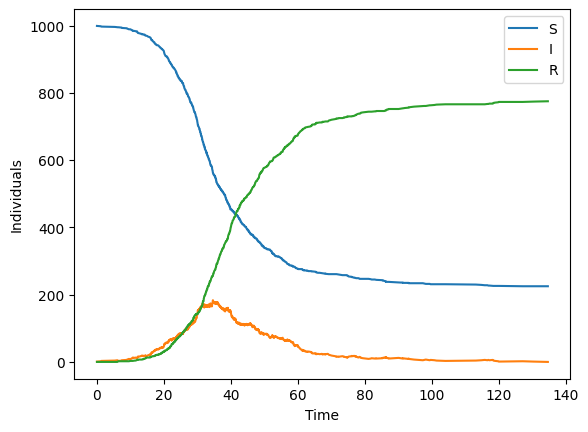

In [11]:
rnd.seed(123)
epi = sir1(beta=0.3, gamma=0.14, S0=999, I0=1, R0=0)

plt.plot(epi['t'], epi['S'], label='S')
plt.plot(epi['t'], epi['I'], label='I')
plt.plot(epi['t'], epi['R'], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

## Problems

* How can we test?
  * are the rates calculated correctly?


* If we want to edit the rates, need to edit `sir1` function
* What if we added another state? `SIR` $\rightarrow$ `SEIR`
* What if we define `sir1` in a separate file to any data?
* What if we want to look at more than one population?
    * or an individual level model?
    
* __How can we make `sir1` more generic__?
    * separation of concerns: rate calculation, random numbers, state update

## Editing rates

Suppose we wish to edit our transition rates
* e.g. introduce another parameter?

$$
\lambda^{SI}(X_t) = \beta I_t^\phi S_t
$$

```python
def sir2(beta, gamma, phi, S0, I0, R0):
  # ...
  si_rate = beta * np.power(I, phi) * S / (S+I+R)
  ir_rate = gamma * I
  # ...
```

* Quickly our `sir2` signature balloons!
* If `sir2` is in a library, a user cannot modify it


* Solution: factor out transition rates into a separate (user-specified) function

In [29]:
def transition_rates(beta, gamma, phi, N):
    """Returns a _closure_ over beta, gamma, phi"""
    def fn(state):
        si_rate = beta * np.power(state['I'], phi) * state['S'] / N
        ir_rate = gamma * state['I']
        return si_rate, ir_rate

    return fn

def sir2(transition_rate_fn, S0, I0, R0):

    S = S0
    I = I0
    R = R0
    N = S0 + I0 + R0
    t = 0

    accum = [(t, S, I, R)]

    while True:

        # Calculate rates
        si_rate, ir_rate = transition_rate_fn(dict(S=S, I=I, R=R))
        total_rate = si_rate + ir_rate

        if total_rate == 0.0: # Break if epidemic stops
            break

        # Draw time to next event, update t
        tstar = np.random.exponential(1.0/total_rate)
        t += tstar

        # Decide if we have an infection (True) or not (False)
        if np.random.uniform() < si_rate / total_rate:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        # Append result to accumulation buffer
        accum.append((t, S, I, R))

    # Reformat results and return
    result = np.array(accum)
    return dict(t=result[:,0], S=result[:,1], I=result[:,2], R=result[:,3])

In [30]:
# Test rate_fn
rate_fn = transition_rates(beta=0.4, gamma=0.14, phi=0.8, N=1000)
rate_fn(state=dict(S=999, I=1, R=0))

(np.float64(0.3996), 0.14)

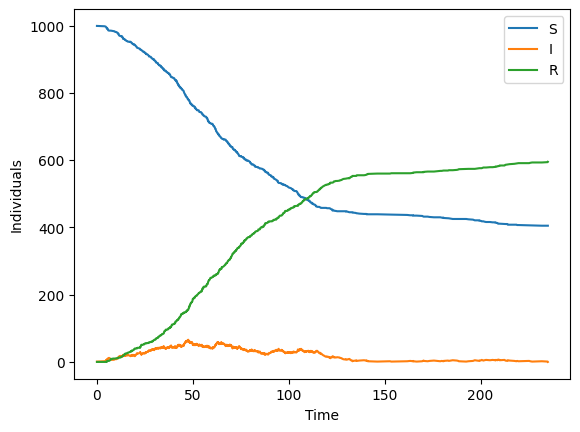

In [33]:
trans_rate_fn = transition_rates(beta=0.4, gamma=0.14, phi=0.8, N=1000)  # close over parameter values
rnd.seed(1)
epi = sir2(trans_rate_fn, S0=999, I0=1, R0=0)

plt.plot(epi['t'], epi['S'], label='S')
plt.plot(epi['t'], epi['I'], label='I')
plt.plot(epi['t'], epi['R'], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

* User-specified transition rate function
    * `trans_rate_fn` allows us to encapsulate parameters, data, etc.
    * __testing__ is easy!


* __Contract__: `sim2` expects `fn(t: float, state: dict) => (si_rate: float, ir_rate: float)`
   * User controls `trans_rate_fn` signature
   * inner function signature `fn(t, state)` is _unchanged_

## Changing the number of states

* `sir2` still stuck with _SIR_ model
* How can we extend to more complex models?

In [ ]:
mm("""
flowchart LR
  S-- "#946;"I/N -->E
  E-- "#948;"E --> I
  S-- "#949;"S --> V
  V-- "#945;#946;"I/N --> E
  I -- "#947;" --> R
""")

### Representing the State Transition Model

Represents the Directed Acyclic Graph using _incidence matrix_, $B$
* e.g. for SIR model


| | SI | IR |
|:-:|:-:|:-:|  
|S | -1 | 0 |
|I | 1 | -1 |
|R | 0 | 1 |

$$B = \begin{pmatrix} -1 & 0 \\
                       1 & -1 \\
                       0 & 1 \\
      \end{pmatrix}
$$

### Incrementing $X_t$

Suppose Step 3 returns a _one hot_ vector representing the transition:

$$
y^\star = \begin{cases} \begin{pmatrix} 1 \\ 0 \end{pmatrix} & S \rightarrow I \\
                        \begin{pmatrix} 0 \\ 1 \end{pmatrix} & I \rightarrow R \\
          \end{cases}
$$

The _increment_ in $X_t = (S_t, I_t, R_t)^T$ is

$$\Delta X_t = B \cdot y^\star$$

for any compatible choice of $y^\star$, $X$, and $B$.

### Incrementing $X_t$

Multiplying $y^\star$ and $B$ allows us to propagate $X_t$ between timepoints:

----

Repeat

1. Compute $\Lambda \leftarrow \sum_{r \in \{SI,IR\}} \lambda^{r}\left(X_t \right)$
2. If $\Lambda = 0$ `break`
3. $t^\star \leftarrow \mbox{Exp}\left( \Lambda \right)$
4. $y^\star \leftarrow \mbox{Discrete}\left(\{\lambda^{SI}(X_t), \lambda^{IR}(X_t)\}\right)$
5. Update

$$
t \leftarrow t + t^\star
$$

and

$$
X_{t+t^\star} = X_t + B \cdot y^\star
$$

----

In [34]:
def cont_time_simulation(transition_rate_fn, initial_state, incidence_matrix):

    current_state = initial_state.copy()
    t = 0

    state_accum = [initial_state]
    t_accum = [t]

    while True:

        # Calculate rates
        rates = transition_rate_fn(current_state)
        total_rate = np.sum(rates)

        if total_rate == 0.0: # Break if epidemic stops
            break

        # Draw time to next event, update t
        tstar = np.random.exponential(1.0/total_rate)
        t += tstar

        # Draw event one hot vector
        next_event = np.random.multinomial(n=1,
                                           pvals=rates/total_rate)

        # Propagate state
        current_state += incidence_matrix.dot(next_event)

        # Append result to accumulation buffer
        state_accum.append(current_state.copy())
        t_accum.append(t)

    # Reformat results and return
    state_result = np.stack(state_accum, axis=0)
    t_result = np.stack(t_accum, axis=0)
    return dict(t=t_result, state=state_result)

In [35]:
# Model specification
incidence_matrix = np.array([[-1, 0],
                             [1, -1],
                             [0, 1]])

# Stacked transition rates
def transition_rates(beta, gamma, phi):
    """Returns a _closure_ over beta, gamma, phi"""
    def fn(state):
        # Enumerate states
        si_rate = beta * np.power(state[1], phi) * state[0] / np.sum(state)
        ir_rate = gamma * state[1]

        return np.stack([si_rate, ir_rate], axis=0)

    return fn

initial_state = [999, 1, 0]

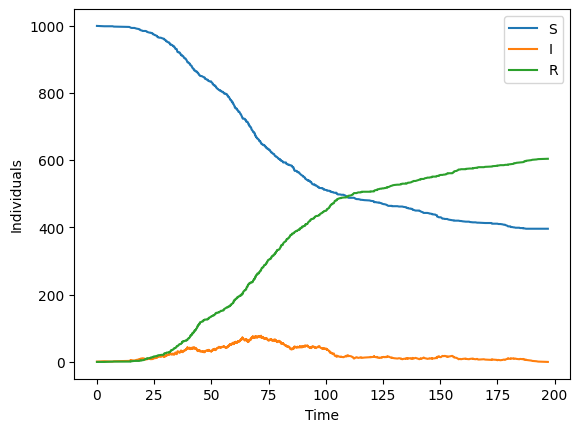

In [36]:
# Run the simulation
rnd.seed(12)
epi = cont_time_simulation(transition_rate_fn=transition_rates(0.4, 0.14, 0.8),
                           initial_state=initial_state,
                           incidence_matrix=incidence_matrix)

plt.plot(epi['t'], epi['state'][:, 0], label='S')
plt.plot(epi['t'], epi['state'][:, 1], label='I')
plt.plot(epi['t'], epi['state'][:, 2], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

## Broadening to more than one population stratum

Suppose for our SIR, we have two neighbouring regions, coupled by a proximity matrix

$$
A = \begin{pmatrix} 0 & 1 \\
                      1 & 0 \\
      \end{pmatrix}
$$

such that

$$
\mathbf{\lambda}^{SI}_i(t, X_t) = \frac{\beta S_{it} (I_{it} + \alpha A \cdot I_t)}{N}
$$

where $\alpha$ represents the force of infection across neighbouring regions.

* Use __batching__...

In [38]:
A = np.array([[0, 1],
              [1, 0]])

initial_state = np.array([[999, 500],
                          [1, 0],
                          [0, 0]])

incidence_matrix = np.array([[-1, 0],
                             [1, -1],
                             [0, 1]])

def transition_rates(alpha, beta, gamma, A):
    """Returns a _closure_ over beta, gamma, phi"""
    def fn(state):
        # Enumerate states
        within_region =  beta * state[1]  # length 2
        between_region = alpha * A.dot(state[1]) # length 2
        si_rate = beta * state[0] * (within_region + between_region) / np.sum(state, axis=0)
        ir_rate = gamma * state[1] # length 2

        return np.stack([si_rate, ir_rate], axis=0) # shape [num_transitions, num_regions]

    return fn

# Test rate function
rate_fn = transition_rates(0.1, 0.4, 0.14, A)
rate_fn(initial_state)

array([[0.15984, 0.04   ],
       [0.14   , 0.     ]])

In [39]:
def cont_time_simulation(transition_rate_fn, initial_state, incidence_matrix):

    current_state = initial_state.copy()
    t = 0

    state_accum = [initial_state]
    t_accum = [t]

    while True:

        # Calculate rates
        rates = transition_rate_fn(current_state) # [num_rates, num_populations]
        total_rate = np.sum(rates)

        if total_rate == 0.0: # Break if epidemic stops
            break

        # Draw time to next event, update t
        tstar = np.random.exponential(1.0/total_rate)
        t += tstar

        # Draw event one hot vector over flattened rates
        next_event = np.random.multinomial(n=1,
                                           pvals=rates.flatten()/total_rate)
        next_event = next_event.reshape(rates.shape)  # [num_rates, num_populations]

        # Propagate state - einsum batches B \dot y over populations
        incr = np.einsum("sr,r...->s...",
                         incidence_matrix,
                         next_event)
        current_state += incr

        # Append result to accumulation buffer
        state_accum.append(current_state.copy())
        t_accum.append(t)

    # Concatenate results and return
    state_result = np.stack(state_accum, axis=0)
    t_result = np.stack(t_accum, axis=0)
    return dict(t=t_result, state=state_result)

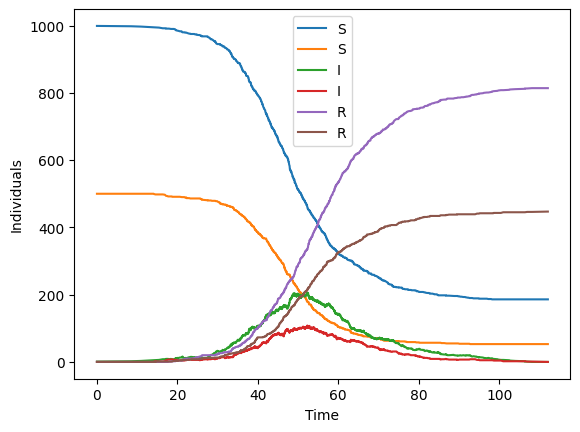

In [41]:
rate_fn = transition_rates(0.1, 0.5, 0.14, A)
rnd.seed(12)
epi = cont_time_simulation(transition_rate_fn=rate_fn,
                           initial_state=initial_state,
                           incidence_matrix=incidence_matrix)

plt.plot(epi['t'], epi['state'][:, 0], label='S')
plt.plot(epi['t'], epi['state'][:, 1], label='I')
plt.plot(epi['t'], epi['state'][:, 2], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

## Conclusions

We have:

* separated the concerns of: _transition rates_, _STM specification_, and _simulation_
* put control of _model specification_ into the hands of the user
* kept _algorithm_ code in the library
* improved testability
* concise, readable code

Potentially we could:

* provide other simulation algorithms (e.g. discrete)
* keep model _specification_ constant
